In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import pystan

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
## load the data for each country
data = []
for country in ['france', 'us', 'uk', 'japan']:
    df = pd.read_csv('../data/idl_'+country+'.csv', sep=';')
    data.append(df)
data = pd.concat(data, axis=0)
data.head()

,Id,Age(years),Age(days since last birthday),Age(days),Sex,Country of birth,Country of death,Date of birth,Date of death,Validation
0,566,110,145,40321,F,FRA,FRA,25/06/1877,17/11/1987,A
1,567,111,286,40828,F,FRA,FRA,19/03/1879,30/12/1990,A
2,568,111,299,40840,F,FRA,FRA,12/02/1881,07/12/1992,A
3,569,110,53,40229,F,FRA,FRA,28/12/1881,19/02/1992,A
4,570,110,108,40285,F,FRA,FRA,18/04/1883,04/08/1993,A


In [3]:
data['yob'] = data['Date of birth'].apply(lambda x: pd.to_datetime(x).year)

In [4]:
data['yod'] = data['Date of death'].apply(lambda x: pd.to_datetime(x).year)

In [5]:
data['aod'] = data['Age(days)']/365.

(array([ 395.,   70.,   36.,   23.,    7.,    1.,    0.,    1.,    0.,    1.]),
 array([ 110. ,  111.2,  112.4,  113.6,  114.8,  116. ,  117.2,  118.4,
         119.6,  120.8,  122. ]),
 <a list of 10 Patch objects>)

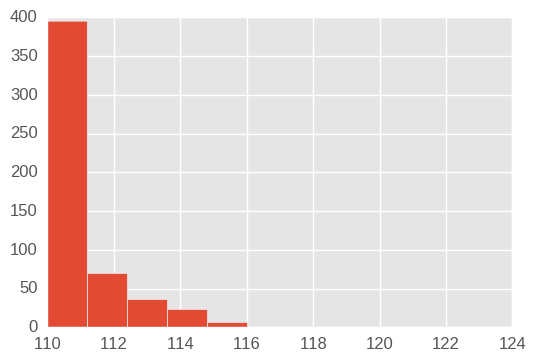

In [6]:
plt.hist(data['Age(years)'])

(array([ 293.,  146.,   52.,   32.,    8.,    0.,    1.,    1.,    0.,    1.]),
 array([ 110.07123288,  111.31726027,  112.56328767,  113.80931507,
         115.05534247,  116.30136986,  117.54739726,  118.79342466,
         120.03945205,  121.28547945,  122.53150685]),
 <a list of 10 Patch objects>)

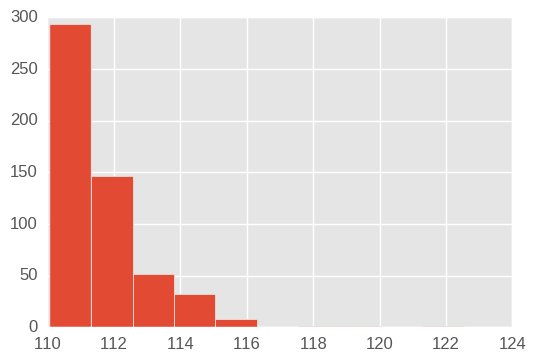

In [7]:
plt.hist(data.aod)

In [8]:
1./(data['Age(years)'].mean() - 109)

0.49674418604651183

In [9]:
((data.yod == 1970) & (data.yob == 1970)).sum()

341

In [10]:
data.loc[((data.yod == 1970) & (data.yob == 1970))].mean()

Id                                 395.000000
Age(years)                         110.961877
Age(days since last birthday)      164.642229
Age(days)                        40692.431085
yob                               1970.000000
yod                               1970.000000
aod                                111.486113
dtype: float64

In [11]:
geom_p = 1./(data.groupby('yob')['Age(years)'].mean() - 109)

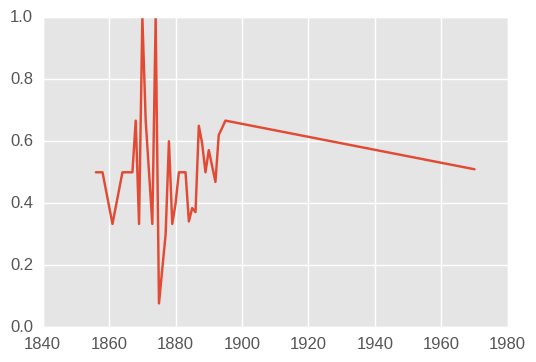

In [12]:
plt.plot(geom_p.index, geom_p)

## Model the lifespans as being generated from a beta distribution with an uknown upper bound

In [13]:
%%writefile 161222_stan_beta_bounded.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death[N]; //ages at death
}

parameters{
    real<lower=max(age_at_death)> max_lifespan;
    real<lower=0> alpha;
    real<lower=0> beta;
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death[i]/max_lifespan;
    }
}

model{
    //priors on parameters
    max_lifespan ~ exponential(1./15.); // give the prior a mean of 15 (125 because relative to 110)
    alpha ~ lognormal(0, 10);
    beta ~ lognormal(0, 10);
    
    // model of age at death
    // increment directly to ensure constants are preserved
    age_transformed ~ beta(alpha, beta);
    target += -N*log(max_lifespan); // need to adjust the lpdf by the range
}


Overwriting 161222_stan_beta_bounded.stan


In [14]:
## compile the stan model
model_beta = pystan.StanModel(file='161222_stan_beta_bounded.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d97816cd388e46d48adf3599d0546fe NOW.


In [15]:
model_data = {
    'N': len(data)
    , 'age_at_death': data.aod - 110
}

In [16]:
fit_beta = model_beta.sampling(model_data, chains=4, iter=20000)

In [17]:
keys = ['max_lifespan', 'alpha', 'beta', 'lp__']
samples = pd.DataFrame({k:fit_beta[k] for k in keys})
samples.describe()

,alpha,beta,lp__,max_lifespan
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.241388,36.033821,-755.700524,45.987210
std,0.070324,15.819382,1.174634,18.556260
min,0.975502,9.299105,-765.116775,15.231293
25%,1.193176,24.642881,-756.238495,32.480251
50%,1.239962,32.667003,-755.397665,42.086427
75%,1.288009,43.817674,-754.837163,55.133178
max,1.577480,176.854035,-754.252181,216.368755


Correctly scaling the beta distribution introduces a natural penalty to increasing the maximum lifespan parameter. Under this model, it suggests that the maximum lifespan is around 155.

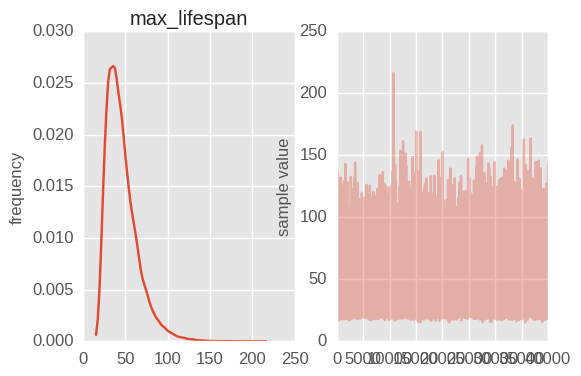

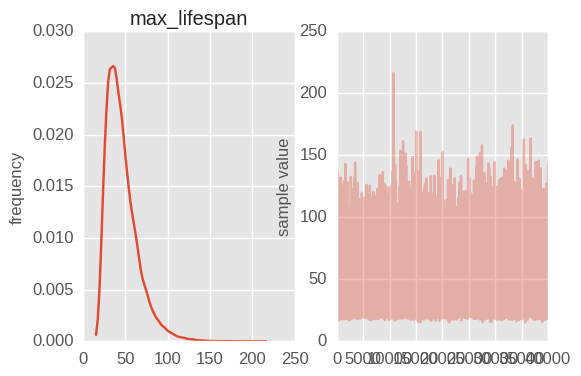

In [18]:
fit_beta.traceplot('max_lifespan')

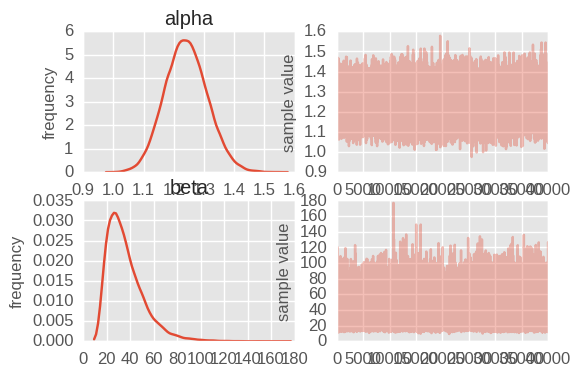

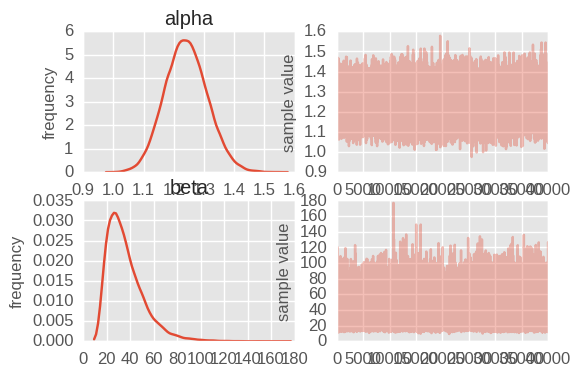

In [19]:
fit_beta.traceplot(['alpha', 'beta'])

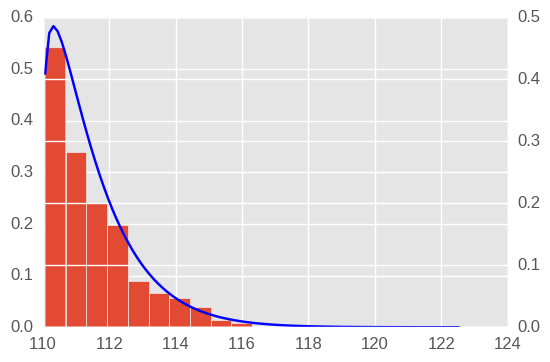

In [20]:
import scipy.stats
ub = fit_beta['max_lifespan'].mean()
x = np.linspace(data.aod.min()-110, data.aod.max()-110, 100)/ub
curve = scipy.stats.beta.pdf(x, fit_beta['alpha'].mean(), fit_beta['beta'].mean())/ub
ax = plt.gca()
ax.hist(data.aod, normed=True, bins=20)
ax.twinx().plot((x*ub)+110, curve, color='blue')

## Poisson model as used in the paper

In [215]:
%%writefile 161222_stan_poisson.stan

data{
    int <lower=0> N; //number of data points
    int <lower=0> age_at_death[N]; //ages at death
}

parameters{
    real<lower=0> lambda;
}

model{
    //priors on parameters
    lambda ~ lognormal(0, 10);
    
    // model of age at death
    age_at_death ~ poisson(lambda);
}


Overwriting 161222_stan_poisson.stan


In [216]:
## compile the stan model
model_poisson = pystan.StanModel(file='161222_stan_poisson.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1afe40e719e2c3519c249dd0d2aef441 NOW.


In [217]:
model_data = {
    'N': len(data)
    , 'age_at_death': data['Age(years)'] - 110
}

In [218]:
fit_poisson = model_poisson.sampling(model_data, chains=1, iter=10000)

In [219]:
fit_poisson

Inference for Stan model: anon_model_1afe40e719e2c3519c249dd0d2aef441.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   1.01  7.7e-4   0.04   0.93   0.99   1.01   1.04   1.09 2731.0    1.0
lp__   -534.3    0.01   0.67 -536.4 -534.5 -534.1 -533.9 -533.9 2048.0    1.0

Samples were drawn using NUTS at Fri Dec 23 00:20:04 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

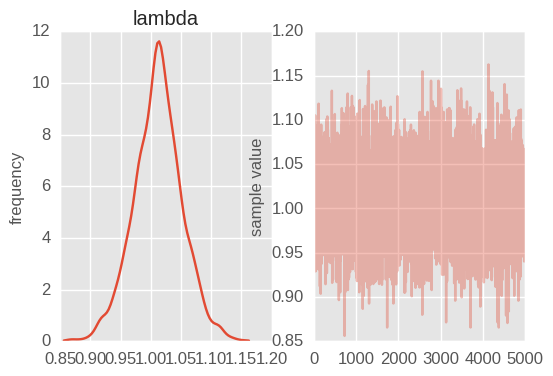

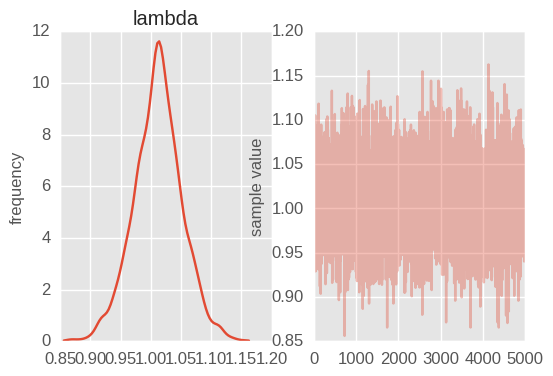

In [220]:
fit_poisson.traceplot()

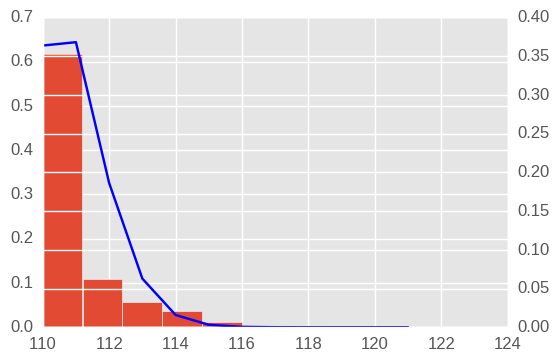

In [354]:
x = np.arange(0, data['Age(years)'].max()-110)
curve = scipy.stats.poisson.pmf(x, fit_poisson['lambda'].mean())
ax = plt.gca()
ax.hist(data['Age(years)'], normed=True)
ax.twinx().plot(x+110, curve, color='blue')

## Mixture of the poisson and beta models for model comparison

In [41]:
%%writefile 161222_stan_mixture.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death_real[N]; //ages at death
    int <lower=0> age_at_death_int[N];
}

parameters{
    //beta dist params
    real<lower=max(age_at_death_real)> max_lifespan;
    real<lower=0> alpha;
    real<lower=0> beta;
    
    //poisson dist params
    real<lower=0> lambda;
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death_real[i]/max_lifespan;
    }
}

model{
        
    vector[2] log_ps;
    
    //priors on parameters
    max_lifespan ~ exponential(1./15.); // give the prior a mean of 15 (125 because relative to 110)
    alpha ~ lognormal(0, 10);
    beta ~ lognormal(0, 10);
    
    lambda ~ lognormal(0, 10);
    
    // model of age at death
    
    // both models should fit the data
    age_transformed ~ beta(alpha, beta);
    target += -N*log(max_lifespan); // range transform
    age_at_death_int ~ poisson(lambda);
    
}

generated quantities{
    // under a uniform prior, the mixing parameter is given by the log likelihood ratio
    real lp_beta;
    real lp_poisson;
    real mix;
    lp_beta = beta_lpdf(age_transformed | alpha, beta) - N*log(max_lifespan);
    lp_poisson = poisson_lpmf(age_at_death_int | lambda);
    
    mix = lp_beta - lp_poisson;
}

Overwriting 161222_stan_mixture.stan


In [42]:
## compile the stan model
model_mixture = pystan.StanModel(file='161222_stan_mixture.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ae18eebec537c3ae352a9cf816b92304 NOW.


In [43]:
model_data = {
    'N': len(data)
    , 'age_at_death_int': data['Age(years)'] - 110
    , 'age_at_death_real': data.aod - 110
}

In [44]:
fit_mixture = model_mixture.sampling(model_data, chains=4, iter=20000)

In [45]:
keys = ['max_lifespan', 'alpha', 'beta', 'lambda', 'mix', 'lp_beta', 'lp_poisson', 'lp__']
samples = pd.DataFrame({k:fit_mixture[k] for k in keys})
samples.describe()

,alpha,beta,lambda,lp__,lp_beta,lp_poisson,max_lifespan,mix
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.239957,35.612697,1.012932,-1290.170331,-755.969930,-795.396286,45.526365,39.426356
std,0.070228,15.671136,0.043381,1.382519,1.249864,0.706915,18.412460,1.433381
min,0.976281,9.687549,0.838605,-1301.051571,-765.790053,-803.984973,15.220115,29.369175
25%,1.191985,24.286634,0.983622,-1290.846414,-756.583497,-795.555780,32.182654,38.681473
50%,1.238901,32.287683,1.012483,-1289.861218,-755.705546,-795.122050,41.587199,39.596554
75%,1.286739,43.345552,1.041743,-1289.154017,-755.062741,-794.949863,54.645170,40.299190
max,1.547588,192.495307,1.193263,-1288.210662,-753.880303,-794.899846,215.009755,49.440448


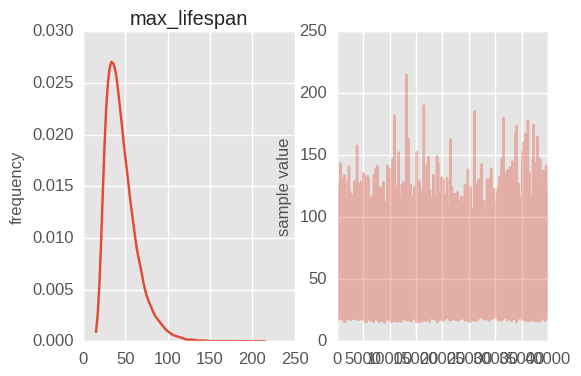

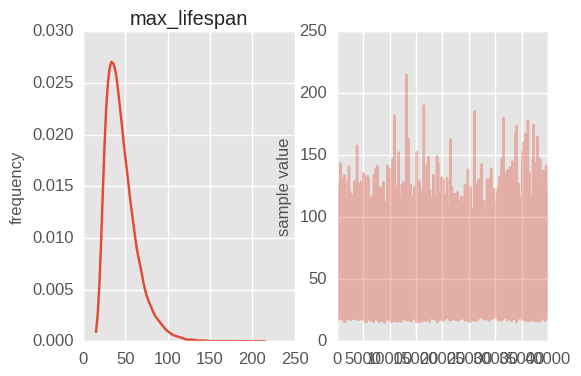

In [46]:
fit_mixture.traceplot('max_lifespan')

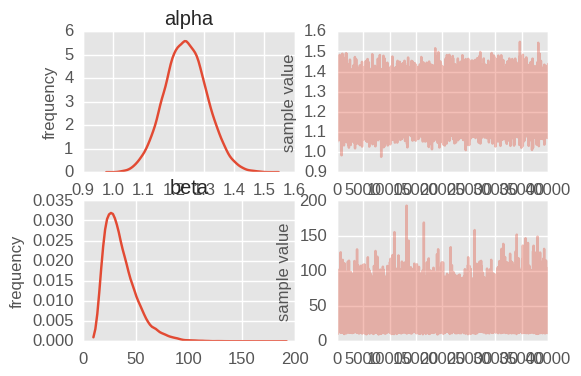

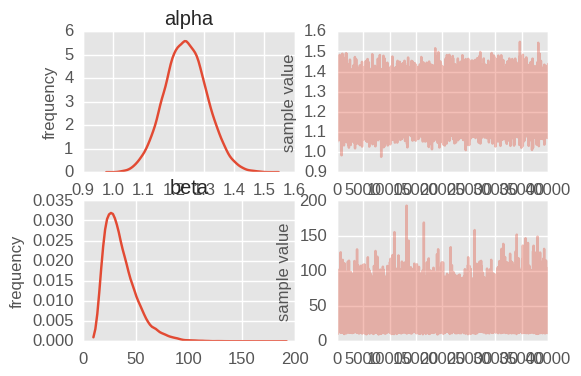

In [47]:
fit_mixture.traceplot(['alpha', 'beta'])

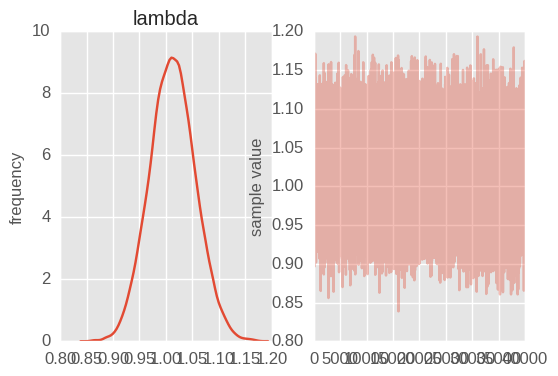

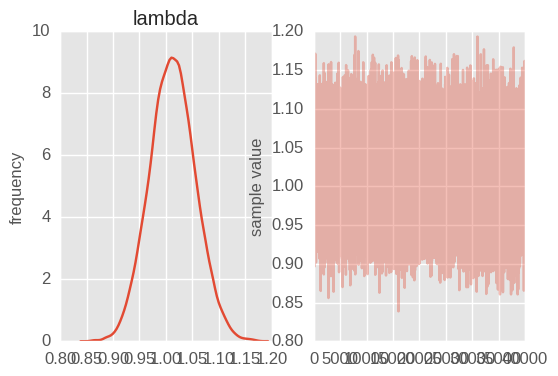

In [48]:
fit_mixture.traceplot('lambda')

The mixing parameter favors the beta model.

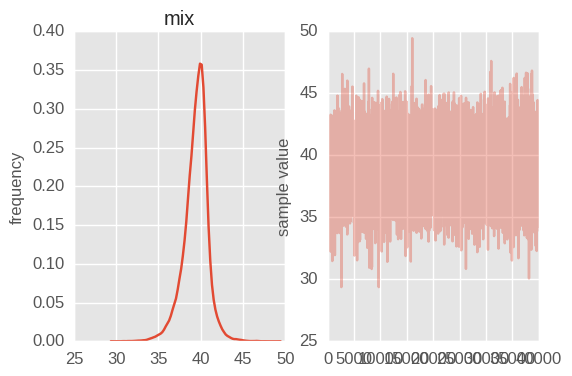

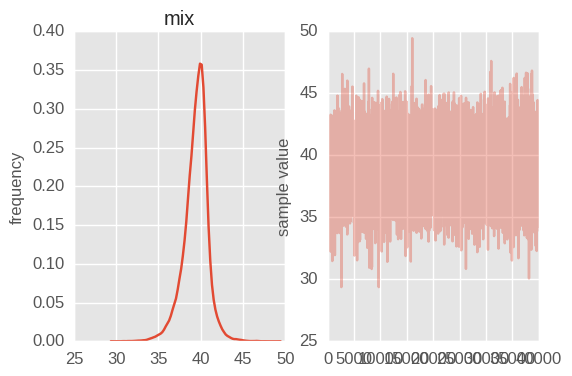

In [49]:
fit_mixture.traceplot('mix')

## Now try a mixture of gamma and beta with random upper bound models
Try a gamma distribution on the lifespans to see if a model without an upper bound but on the real numbers performs better

In [50]:
%%writefile 161222_stan_mixture2.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death[N]; //ages at death
}

parameters{
    //beta dist params
    real<lower=max(age_at_death)> max_lifespan;
    real<lower=0> alpha[2];
    real<lower=0> beta[2];
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death[i]/max_lifespan;
    }
}

model{
    
    //priors on parameters
    max_lifespan ~ exponential(1./15.); // give the prior a mean of 15 (125 because relative to 110)
    alpha ~ lognormal(0, 10);
    beta ~ lognormal(0, 10);
    
    // model of age at death
    
    // both models should fit the data
    age_transformed ~ beta(alpha[1], beta[1]);
    target += -N*log(max_lifespan);
    age_at_death ~ gamma(alpha[2], beta[2]);
    
}

generated quantities{
    // under a uniform prior, the mixing parameter is given by the log likelihood ratio
    real lp_beta;
    real lp_gamma;
    real mix;
    lp_beta = beta_lpdf(age_transformed | alpha[1], beta[1]) - N*log(max_lifespan);
    lp_gamma = gamma_lpdf(age_at_death | alpha[2], beta[2]);
    
    mix = lp_beta - lp_gamma;
    
}

Overwriting 161222_stan_mixture2.stan


In [51]:
## compile the stan model
model_mixture2 = pystan.StanModel(file='161222_stan_mixture2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac770169390a98f8d3797925a4bec4ab NOW.


In [52]:
model_data = {
    'N': len(data)
    , 'age_at_death': data.aod - 110
}

In [53]:
fit_mixture2 = model_mixture2.sampling(model_data, chains=4, iter=20000)

In [55]:
keys = ['max_lifespan', 'alpha', 'beta', 'mix', 'lp_beta', 'lp_gamma', 'lp__']
samples = pd.concat({k:pd.DataFrame(fit_mixture2[k]) for k in keys}, axis=1)
samples.describe()

alpha                        beta                        lp__  \
                  0             1             0             1             0   
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean       1.240871      1.287569     35.645597      0.837393  -1510.346437   
std        0.069932      0.069399     15.824584      0.055129      1.547515   
min        0.974097      0.991271      9.076095      0.625745  -1522.260164   
25%        1.192826      1.239850     24.433688      0.799971  -1511.139059   
50%        1.239513      1.286199     32.070082      0.836316  -1510.020522   
75%        1.287280      1.333994     43.255956      0.873840  -1509.211186   
max        1.539538      1.598272    161.475501      1.077048  -1507.947503   

            lp_beta      lp_gamma  max_lifespan           mix  
                  0             0             0             0  
count  40000.000000  40000.000000  40000.000000  40000.000000  
mean    -755.964874   -754.630075     45.541420     -1.334800  
std        1.245806      0.975732     18.624273      1.582887  
min     -768.307127   -764.320521     15.011969    -14.177465  
25%     -756.575957   -755.006704     32.252969     -2.194626  
50%     -755.697625   -754.328902     41.415671     -1.255859  
75%     -755.068327   -753.936469     54.542398     -0.442629  
max     -753.888500   -753.654632    191.179002      9.025525

With the gamma lifespan model, we see that a model without an upper bound on lifespan performs better than the bounded model. This suggests that the lifespan data does not support the conclusion that there is a biologically fixed maximum lifespan.

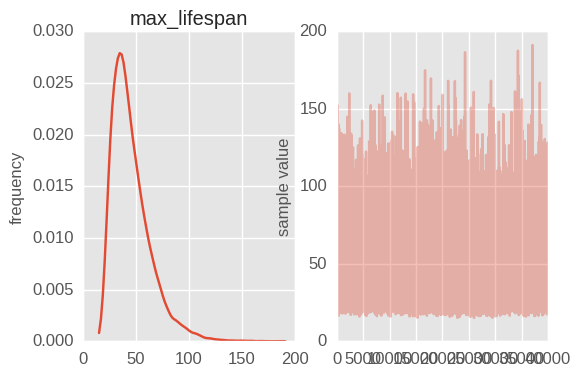

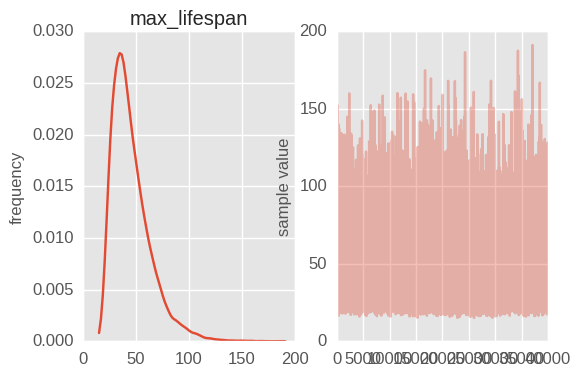

In [56]:
fit_mixture2.traceplot('max_lifespan')

In [57]:
to_plot = samples[['alpha', 'beta']].stack().stack()
to_plot = pd.DataFrame(to_plot).reset_index([1,2])
to_plot.columns = ['Model', 'Parameter', 'Value']
#to_plot.head()

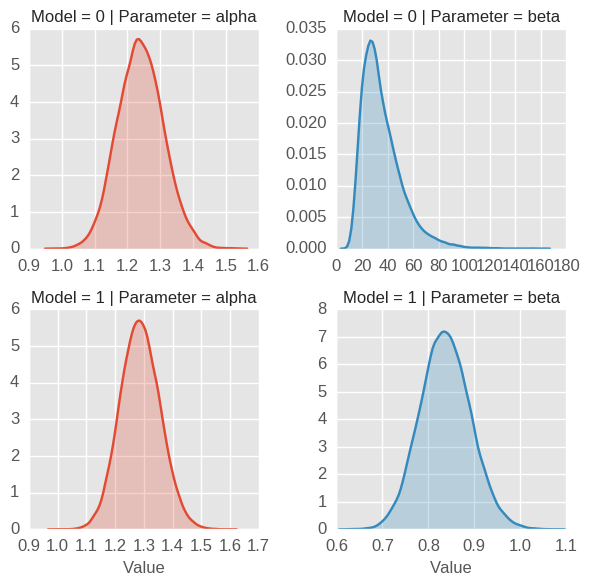

In [58]:
g = sns.FacetGrid(to_plot, row='Model', col='Parameter', hue='Parameter', sharex=False, sharey=False)
g.map(sns.kdeplot, 'Value', shade=True)

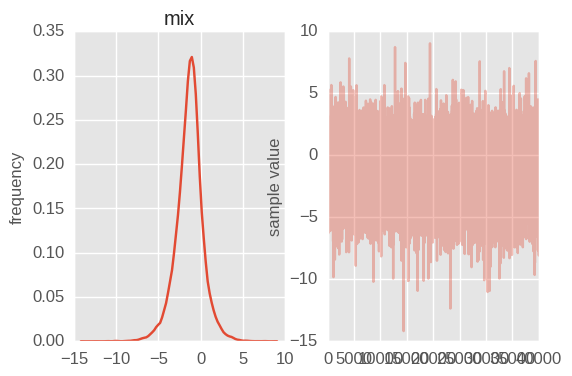

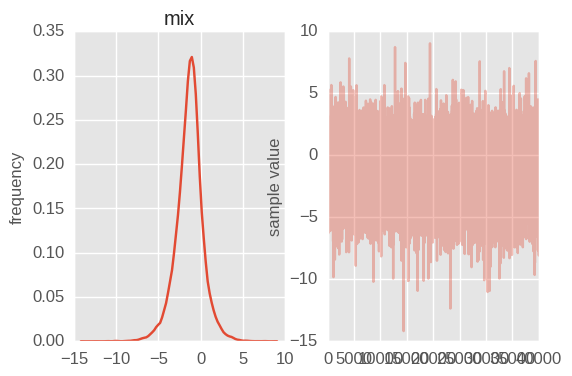

In [59]:
fit_mixture2.traceplot('mix')

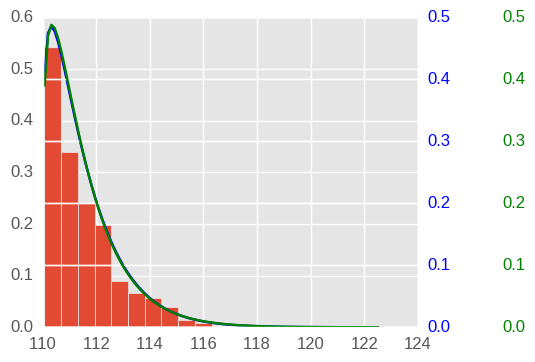

In [61]:

ub = fit_mixture2['max_lifespan'].mean()
x = np.linspace(data.aod.min()-110, data.aod.max()-110, 100)/ub
x2 = np.linspace(data.aod.min()-110, data.aod.max()-110, 100)
curve = scipy.stats.beta.pdf(x, fit_mixture2['alpha'][:,0].mean(), fit_mixture2['beta'][:,0].mean())/ub
gamma_alpha = fit_mixture2['alpha'][:,1].mean()
gamma_scale = 1./fit_mixture2['beta'][:,1].mean()
curv2 = scipy.stats.gamma.pdf(x2, gamma_alpha, scale=gamma_scale)

fig, ax = plt.subplots()
axes = [ax, ax.twinx(), ax.twinx()]
# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)
# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))
# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

axes[0].hist(data.aod, normed=True, bins=20)
axes[1].plot(x*ub+110, curve, color='blue')
axes[1].tick_params(axis='y', colors='blue')
axes[2].plot(x2+110, curv2, color='green')
axes[2].tick_params(axis='y', colors='green')